In [40]:
import os
import kagglehub
import cv2
import random
import shutil
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import pandas as pd 
import torch.nn.functional as F
from torchvision.models import ResNet18_Weights
from PIL import Image
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from torchvision.models import resnet18
import matplotlib.pyplot as plt

In [41]:
path = "/kaggle/input/food11"
subfolder_path = "/kaggle/working/foodimage"

if not os.path.exists(subfolder_path):
    os.makedirs(subfolder_path)

for root, dirs, files in os.walk(path):
    parent_folder = os.path.basename(root)
    if parent_folder in ['test', 'train']:
        for subdir in dirs:
            subdir_path = os.path.join(root, subdir)
            category_folder = os.path.join(subfolder_path, subdir)

            if not os.path.exists(category_folder):
                os.makedirs(category_folder)

            for file in os.listdir(subdir_path):
                if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                    original_file_path = os.path.join(subdir_path, file)
                    new_file_path = os.path.join(category_folder, file)

                    shutil.copy2(original_file_path, new_file_path)

print("Tüm görseller başarıyla kategorilere göre kopyalandı!")


Tüm görseller başarıyla kategorilere göre kopyalandı!


In [42]:
def load_dataset(image_dir):
    images = []
    labels = []
    
    categories = ["apple_pie", "cheesecake", "chicken_curry", "french_fries",
                  "fried_rice", "hamburger", "hot_dog", "ice_cream", 
                  "omelette", "pizza", "sushi"]
    label_map = {category: idx for idx, category in enumerate(categories)}

    for category in categories:
        category_path = os.path.join(image_dir, category)
        if not os.path.exists(category_path):
            print(f"Klasör eksik: {category} - {category_path}")
            continue

        image_files = os.listdir(category_path)

        if not image_files:
            print(f"Resim dosyası bulunamadı: {category}")
            continue
        random.shuffle(image_files)

        for image_name in image_files[:1000]:
            image_path = os.path.join(category_path, image_name)
            image = cv2.imread(image_path)
            if image is not None:
                image = cv2.resize(image, (64, 64))
                images.append(image)
                labels.append(label_map[category])
            else:
                print(f"Resim okunamadı: {image_name}")
    images = np.array(images)
    labels = np.array(labels)
    
    return images, labels

image_dir = "/kaggle/working/foodimage"
images, labels = load_dataset(image_dir)

print(f"Yüklenen resimler: {images.shape}")
print(f"Yüklenen etiketler: {labels.shape}")

Yüklenen resimler: (11000, 64, 64, 3)
Yüklenen etiketler: (11000,)


In [43]:
class FocalLoss(nn.Module):
    def __init__(self, gamma=2, alpha=0.25):
        super(FocalLoss, self).__init__()
        self.gamma = gamma
        self.alpha = alpha

    def forward(self, inputs, targets):
        BCE_loss = F.cross_entropy(inputs, targets, reduction='none') 
        pt = torch.exp(-BCE_loss)
        F_loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return F_loss.mean()

In [44]:
train_images, test_images, train_labels, test_labels = train_test_split(images, labels, test_size=0.2, random_state=42)

transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

In [45]:
class CustomDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        image = Image.fromarray(image)
        
        if self.transform:
            image = self.transform(image)

        return image, label

In [46]:
train_dataset = CustomDataset(train_images, train_labels, transform=transform)
test_dataset = CustomDataset(test_images, test_labels, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [47]:
class CNN_Food(nn.Module):
    def __init__(self, num_classes):
        super(CNN_Food, self).__init__()

        self.conv1 = nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3, padding=1, stride=1)
        self.bn1 = nn.BatchNorm2d(32)
        self.relu1 = nn.ReLU()

        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1, stride=1)
        self.bn2 = nn.BatchNorm2d(64)
        self.relu2 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1, stride=1)
        self.bn3 = nn.BatchNorm2d(128)
        self.relu3 = nn.ReLU()
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.global_avg_pool = nn.AdaptiveAvgPool2d((1, 1))
        self.flatten = nn.Flatten()
        self.fc = nn.Linear(128, 11)
        #self.dropout = nn.Dropout(0.3)
        
    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.pool1(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)
        x = self.pool2(x)

        x = self.global_avg_pool(x)
        x = self.flatten(x)
        x = self.fc(x)
        return x

num_classes = 11 
model = CNN_Food(num_classes)

class ResNet_Food(nn.Module):
    def __init__(self, num_classes):
        super(ResNet_Food, self).__init__()
        self.resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
        self.resnet.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        self.resnet.fc = nn.Linear(self.resnet.fc.in_features, num_classes)

    def forward(self, x):
        return self.resnet(x)

resnet_model = ResNet_Food(num_classes)

criterion = FocalLoss(gamma=2, alpha=0.25)
optimizer_cnn = optim.Adam(model.parameters(), lr=0.0005)
optimizer_resnet = optim.Adam(resnet_model.parameters(), lr=0.0005)

In [48]:
def train(model, train_loader, optimizer, criterion, epochs=30):
    model.train()
    train_losses, train_accuracies = [], []
    
    for epoch in range(epochs):
        running_loss, correct, total = 0.0, 0, 0
        
        for images, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            correct += (preds == labels).sum().item()
            total += labels.size(0)
        
        train_losses.append(running_loss / len(train_loader))
        train_accuracies.append(correct / total)
        
        print(f"Epoch [{epoch+1}/{epochs}] Loss: {running_loss/len(train_loader):.4f}, Accuracy: {correct/total:.4f}")
    
    return train_losses, train_accuracies

In [49]:
def evaluate(model, test_loader):
    model.eval()
    all_labels, all_preds = [], []
    
    with torch.no_grad():
        for images, labels in test_loader:
            outputs = model(images)
            _, preds = torch.max(outputs, 1)
            all_labels.extend(labels.numpy())
            all_preds.extend(preds.numpy())
    
    print("Classification Report:\n", classification_report(all_labels, all_preds))
    return all_labels, all_preds

In [50]:
cnn_train_losses, cnn_train_accuracies = train(model, train_loader, optimizer_cnn, criterion, epochs=30)

cnn_labels, cnn_preds = evaluate(model, test_loader)

resnet_train_losses, resnet_train_accuracies = train(resnet_model, train_loader, optimizer_resnet, criterion, epochs=30)
resnet_labels, resnet_preds = evaluate(resnet_model, test_loader)

Epoch [1/30] Loss: 0.4493, Accuracy: 0.2126
Epoch [2/30] Loss: 0.4081, Accuracy: 0.2834
Epoch [3/30] Loss: 0.3877, Accuracy: 0.3120
Epoch [4/30] Loss: 0.3780, Accuracy: 0.3293
Epoch [5/30] Loss: 0.3696, Accuracy: 0.3375
Epoch [6/30] Loss: 0.3643, Accuracy: 0.3509
Epoch [7/30] Loss: 0.3600, Accuracy: 0.3566
Epoch [8/30] Loss: 0.3553, Accuracy: 0.3625
Epoch [9/30] Loss: 0.3494, Accuracy: 0.3707
Epoch [10/30] Loss: 0.3466, Accuracy: 0.3750
Epoch [11/30] Loss: 0.3428, Accuracy: 0.3775
Epoch [12/30] Loss: 0.3408, Accuracy: 0.3840
Epoch [13/30] Loss: 0.3372, Accuracy: 0.3895
Epoch [14/30] Loss: 0.3349, Accuracy: 0.3940
Epoch [15/30] Loss: 0.3327, Accuracy: 0.3990
Epoch [16/30] Loss: 0.3310, Accuracy: 0.4011
Epoch [17/30] Loss: 0.3279, Accuracy: 0.3994
Epoch [18/30] Loss: 0.3265, Accuracy: 0.4033
Epoch [19/30] Loss: 0.3246, Accuracy: 0.4086
Epoch [20/30] Loss: 0.3246, Accuracy: 0.4072
Epoch [21/30] Loss: 0.3213, Accuracy: 0.4131
Epoch [22/30] Loss: 0.3172, Accuracy: 0.4215
Epoch [23/30] Loss:

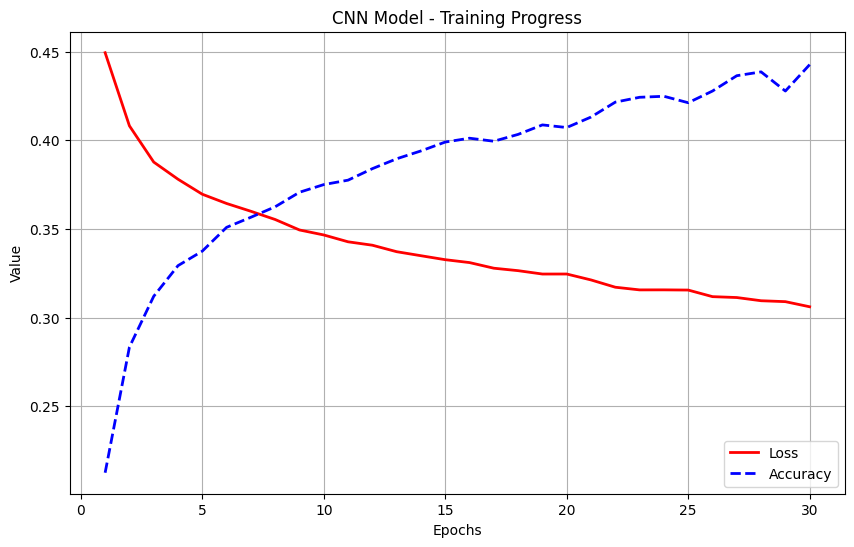

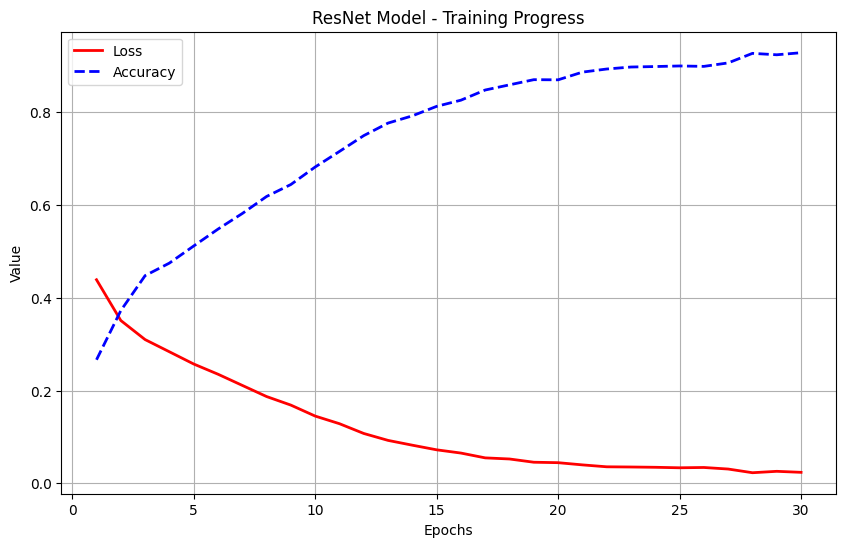

In [51]:
def plot_training_graphs(losses, accuracies, title):
    epochs = range(1, len(losses) + 1)
    
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, losses, label="Loss", color="red", linestyle='-', linewidth=2)
    plt.plot(epochs, accuracies, label="Accuracy", color="blue", linestyle='--', linewidth=2)
    plt.title(f"{title} - Training Progress")
    plt.xlabel("Epochs")
    plt.ylabel("Value")
    plt.legend()
    plt.grid(True)
    plt.show()

plot_training_graphs(cnn_train_losses, cnn_train_accuracies, "CNN Model")
plot_training_graphs(resnet_train_losses, resnet_train_accuracies, "ResNet Model")